In [24]:
#%% -------- 1. Enhanced Configuration Cell --------
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
import splitfolders
from torch.optim.lr_scheduler import OneCycleLR
import torchmetrics
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Hardware config
NUM_CLASSES = 1  # Binary classification
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
PRECISION = '16-mixed'
EPOCHS = 250
LR = 3e-5  # Increased learning rate
WARMUP_EPOCHS = 3
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial Plexus\\1st Classification"
SPLIT_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial Plexus\\Split_Dataset"
SEED = 42

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

Seed set to 42


42

In [25]:
#%% -------- 2. Enhanced Data Preparation Cell --------
def prepare_dataset():
    splitfolders.ratio(
        DATA_ROOT,
        output=SPLIT_ROOT,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

if not os.path.exists(os.path.join(SPLIT_ROOT, 'train')):
    prepare_dataset()

# Enhanced MRI-specific transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Fixed normalization for 3 channels
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
train_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'val'), val_transform)
test_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'test'), val_transform)

# Class balancing with pos_weight
class_counts = np.bincount(train_dataset.targets)
pos_weight = torch.tensor([class_counts[0]/class_counts[1]], dtype=torch.float32)
samples_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

Copying files: 970 files [00:01, 665.68 files/s]


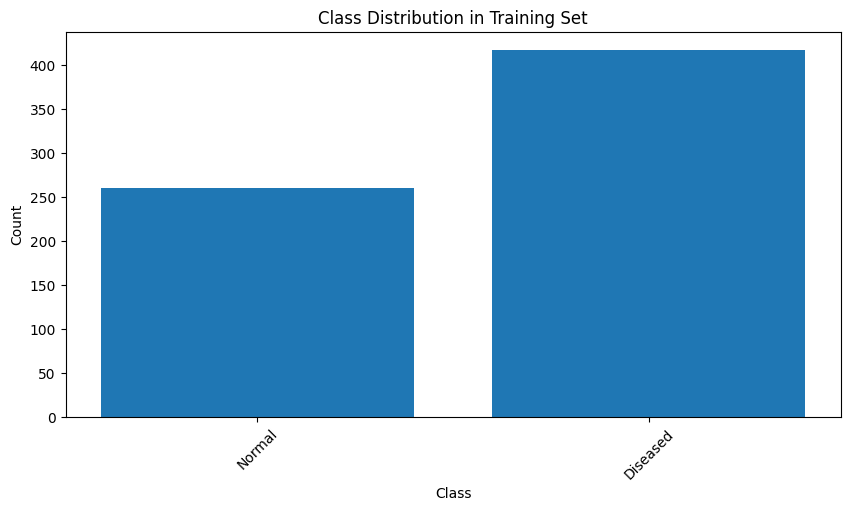

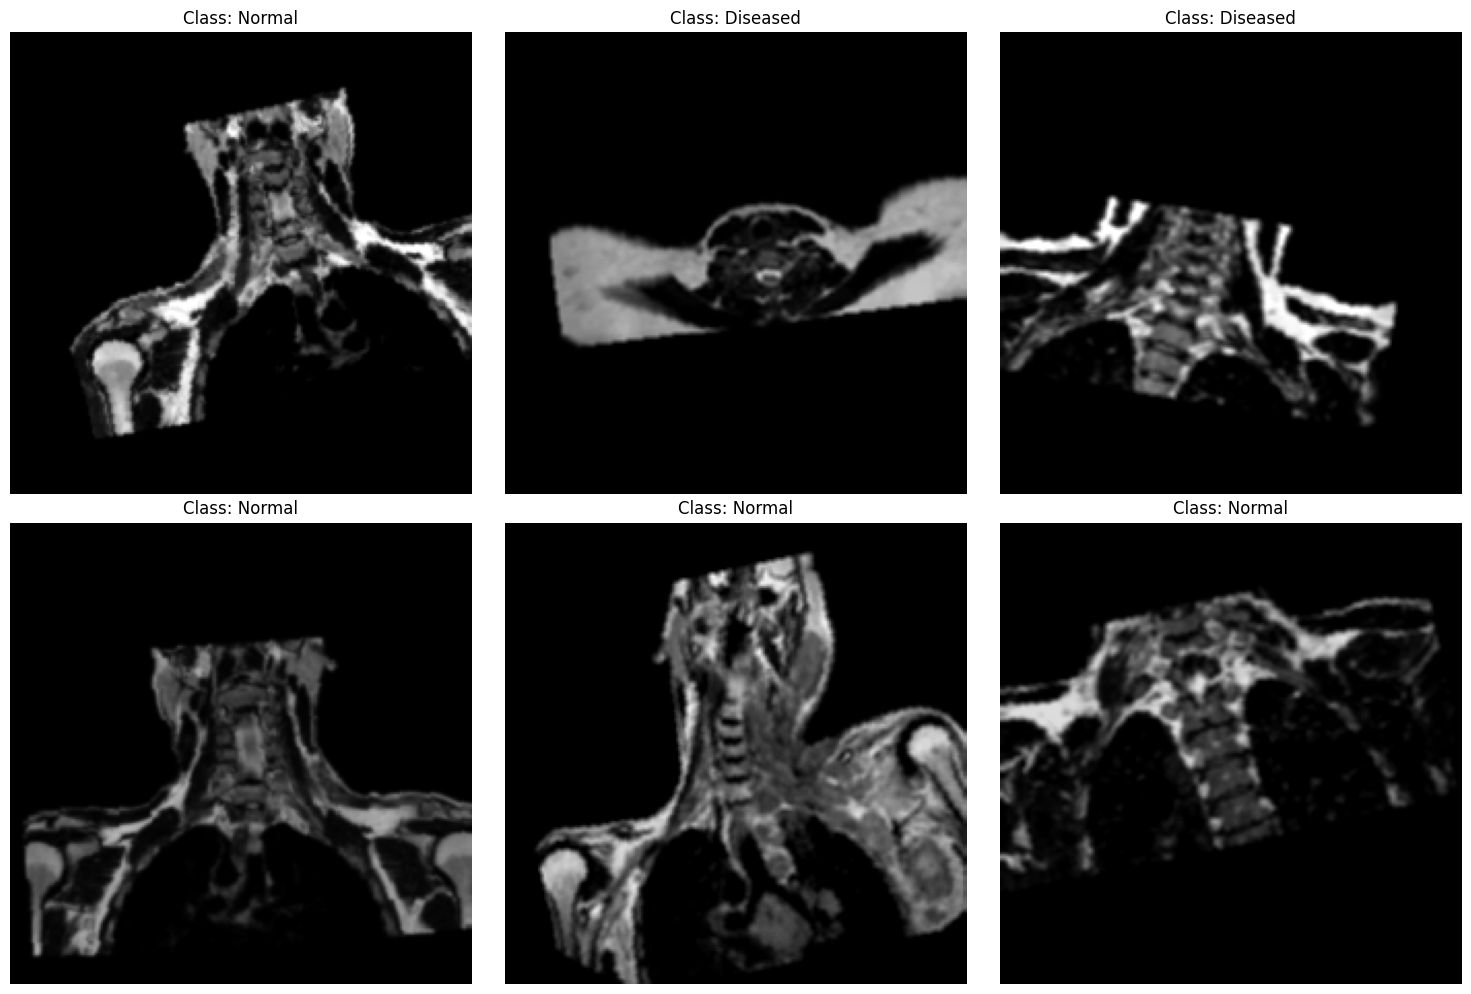

In [26]:
#%% -------- 3. Data Visualization Cell --------
class_names = ['Normal', 'Diseased']  # Manual mapping based on folder names

def plot_class_distribution():
    counts = np.bincount(train_dataset.targets)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(2, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_distribution()
show_sample_images(train_dataset)

In [27]:
#%% -------- 4. Enhanced Model Definition Cell --------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return loss.mean()

class BrachialPlexusResMT(nn.Module):
    def __init__(self, img_size=224, patch_size=32, embed_dim=512, 
                 num_heads=8, num_layers=3, dropout=0.2):  # Reduced layers, increased dropout
        super().__init__()
        
        # ResNet-50 Backbone with partial unfreezing
        self.cnn_backbone = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(self.cnn_backbone.children())[:-2])
        
        # Freeze initial layers
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False
            
        # Unfreeze last residual block
        for param in self.cnn_backbone[-1].parameters():  # Layer4
            param.requires_grad = True

        # Feature adaptation
        self.feature_adapt = nn.Sequential(
            nn.Conv2d(2048, embed_dim, 1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(49, 1, embed_dim))
        
        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            embed_dim, num_heads, dim_feedforward=2048, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
        # Enhanced Classifier with dropout
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.5),  # Added dropout
            nn.Linear(embed_dim, 1)
        )

    def forward(self, x):
        x = self.cnn_backbone(x)
        x = self.feature_adapt(x)
        x = x.flatten(2).permute(2, 0, 1)
        x = x + self.positional_encoding
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        return self.classifier(x)

In [28]:
#%% -------- 5. Enhanced Training Setup Cell --------
class LitModel(pl.LightningModule):
    def __init__(self, total_steps):
        super().__init__()
        self.save_hyperparameters()
        self.model = BrachialPlexusResMT()
        self.criterion = FocalLoss(alpha=0.75)  # Using focal loss
        self.pos_weight = pos_weight
        
        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='binary').to(self.device)
        self.train_auc = torchmetrics.AUROC(task='binary').to(self.device)
        self.val_acc = torchmetrics.Accuracy(task='binary').to(self.device)
        self.val_auc = torchmetrics.AUROC(task='binary').to(self.device)
        
        # History tracking
        self.training_loss = []
        self.validation_loss = []
        self.training_acc = []
        self.validation_acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = torch.sigmoid(logits)
        self.train_acc(probs, y)
        self.train_auc(probs, y)
        
        self.log_dict({'train_loss': loss, 'train_acc': self.train_acc, 'train_auc': self.train_auc},
                     prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = torch.sigmoid(logits)
        self.val_acc(probs, y)
        self.val_auc(probs, y)
        
        self.log_dict({'val_loss': loss, 'val_acc': self.val_acc, 'val_auc': self.val_auc},
                     prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Differential learning rates
        backbone_params = []
        new_params = []
        for name, param in self.named_parameters():
            if 'cnn_backbone.layer4' in name:
                backbone_params.append(param)
            else:
                new_params.append(param)
        
        optimizer = optim.AdamW(
            [
                {'params': backbone_params, 'lr': LR/10},
                {'params': new_params, 'lr': LR}
            ],
            weight_decay=0.01
        )
        
        scheduler = OneCycleLR(
            optimizer,
            max_lr=[LR/10, LR],
            total_steps=self.hparams.total_steps
        )
        return [optimizer], [scheduler]

# Initialize
train_loader = DataLoader(train_dataset, BATCH_SIZE, sampler=sampler, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, num_workers=NUM_WORKERS,
                       pin_memory=True)
model = LitModel(total_steps=EPOCHS*len(train_loader))

# Callbacks
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_auc',
    mode='max',
    filename='best-{epoch}-{val_auc:.3f}',
    save_top_k=2
)

early_stop = pl.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,  # Increased patience
    mode='max',
    min_delta=0.005
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=EPOCHS,
    precision=PRECISION,
    callbacks=[checkpoint, early_stop],
    accumulate_grad_batches=4,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    deterministic="warn"
)

c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Program Files\Python311\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
C:\Users\DELL 5540\AppData\Roaming\Pyt

In [29]:
#%% -------- 6. Training Execution Cell --------
trainer.fit(model, train_loader, val_loader)
best_model = LitModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

Missing logger folder: c:\Users\DELL 5540\Desktop\Brachial plexus\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | BrachialPlexusResMT | 34.0 M
1 | criterion | FocalLoss           | 0     
2 | train_acc | BinaryAccuracy      | 0     
3 | train_auc | BinaryAUROC         | 0     
4 | val_acc   | BinaryAccuracy      | 0     
5 | val_auc   | BinaryAUROC         | 0     
--------------------------------------------------
25.5 M    Trainable params
8.5 M     Non-trainable params
34.0 M    Total params
136.168   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\data.py:220: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:95.)
  return torch.cumsum(x, dim=dim, dtype=dtype)
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zer

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\fabric\utilities\cloud_io.py:55: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


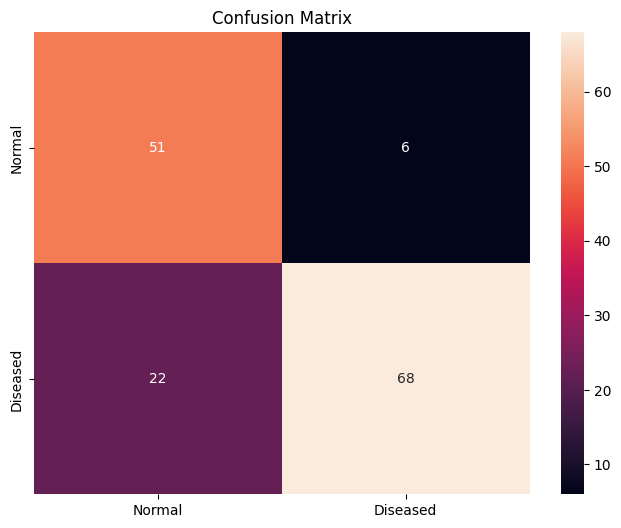

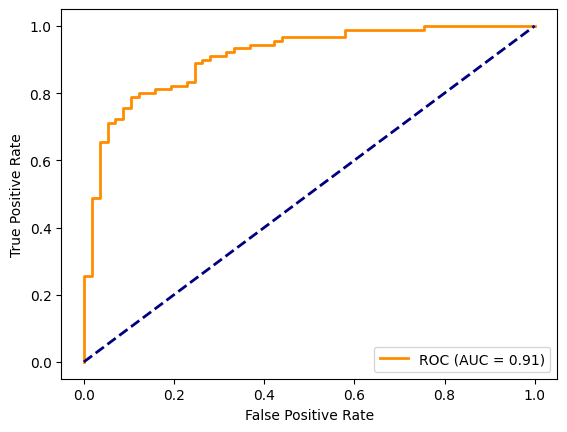

              precision    recall  f1-score   support

      Normal       0.70      0.89      0.78        57
    Diseased       0.92      0.76      0.83        90

    accuracy                           0.81       147
   macro avg       0.81      0.83      0.81       147
weighted avg       0.83      0.81      0.81       147



In [30]:
#%% -------- 7. Enhanced Evaluation with TTA --------
def evaluate():
    best_model.eval()
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(best_model.device), y.to(best_model.device)
            
            # Test-time augmentation
            logits = best_model(x)
            logits_flipped = best_model(torch.flip(x, [3]))  # Horizontal flip
            avg_logits = (logits + logits_flipped) / 2
            
            probs = torch.sigmoid(avg_logits)
            preds = (probs > 0.5).float()
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Visualization and metrics
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.show()
    
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    print(classification_report(all_targets, all_preds, target_names=class_names))

evaluate()

In [35]:
#%% -------- 7. Enhanced Training Curves Visualization Cell --------
def plot_training_curves():
    plt.figure(figsize=(18, 6))
    
    # Convert to numpy arrays for plotting
    train_loss = torch.stack(model.training_loss).numpy()
    val_loss = torch.stack(model.validation_loss).numpy()
    train_acc = torch.stack(model.training_acc).numpy()
    val_acc = torch.stack(model.validation_acc).numpy()
    
    # Smoothed curves (EMA)
    smooth_factor = 0.8
    train_loss_smoothed = np.convolve(train_loss, np.ones(smooth_factor)/smooth_factor, mode='valid')
    val_loss_smoothed = np.convolve(val_loss, np.ones(smooth_factor)/smooth_factor, mode='valid')
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(train_loss, alpha=0.2, label='Train Loss (Raw)')
    plt.plot(train_loss_smoothed, label=f'Train Loss (Smoothed)')
    plt.plot(val_loss, alpha=0.2, label='Val Loss (Raw)')
    plt.plot(val_loss_smoothed, label='Val Loss (Smoothed)')
    plt.title('Loss Curves')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy Progression')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    
    # LR History
    lrs = np.array([h['lr'] for h in model.trainer.lr_scheduler_configs[0].scheduler.history])
    plt.subplot(1, 3, 3)
    plt.plot(lrs)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_training_curves()

# Additional metrics analysis
def analyze_training_dynamics():
    # Find best validation point
    best_epoch = np.argmax(model.validation_acc)
    print(f"\nBest Validation Performance:")
    print(f"Epoch: {best_epoch+1}/{EPOCHS}")
    print(f"Loss: {model.validation_loss[best_epoch]:.4f}")
    print(f"Accuracy: {model.validation_acc[best_epoch]:.4f}")
    
    # Check for overfitting
    final_train_acc = model.training_acc[-1]
    final_val_acc = model.validation_acc[-1]
    gap = final_train_acc - final_val_acc
    print(f"\nGeneralization Gap: {gap:.4f} ({'OK' if gap < 0.2 else 'Overfitting!'})")

analyze_training_dynamics()

RuntimeError: stack expects a non-empty TensorList

<Figure size 1800x600 with 0 Axes>

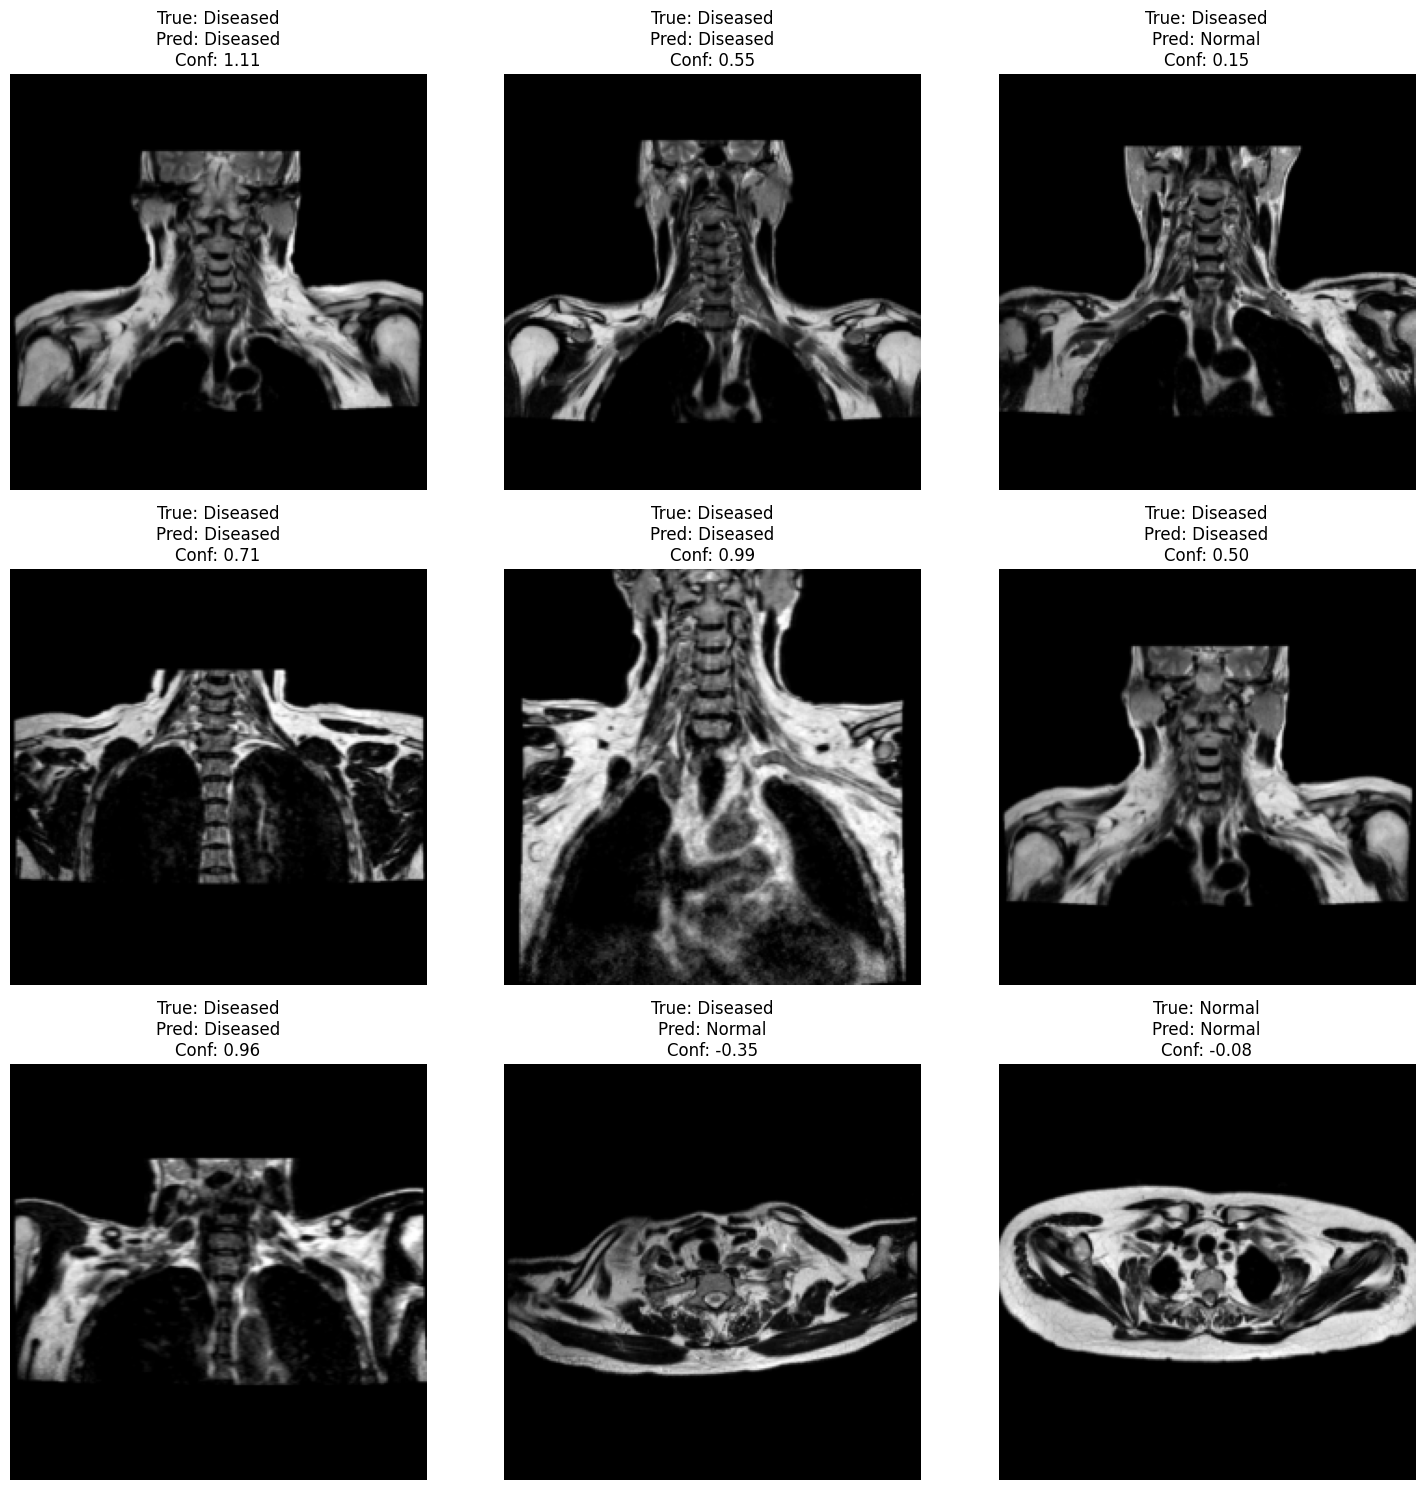

Full pipeline execution completed!


In [34]:
#%% -------- 9. Inference Visualization Cell --------
def predict_and_visualize(model, dataset, num_images=9):
    model.eval()
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, true_label = dataset[idx]
        img_tensor = img.unsqueeze(0).to(model.device)
        
        with torch.no_grad():
            prob = model(img_tensor).item()
            pred_label = int(prob > 0.5)
        
        img_np = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {prob:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(best_model, test_dataset)

print("Full pipeline execution completed!")